## EXPLORATORY DATA ANALYSIS OF DATA

The goal of this project is to build a recommendation engine to recommend product to the customers based on their previous interaction with the store. This project has two phases
* The candidate generation : This phases generate the n-possible product for the user 
* Reranker : This rrerankers the possible product  and tailors it to the user, reranking the most relevant to the user

## DATASET
This dataset contains 20M users' events from eCommerce website, This file contains behavior data for 5 months (Oct 2019 – Feb 2020) from a medium cosmetics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.



There are different types of events. See below.

### Semantics (or how to read it):

User user_id during session user_session added to shopping cart (property event_type is equal cart) 

product product_id of brand brand of category category_code (category_code) with price price at event_time

File structure
Property	            Description

**event_time**	Time when event happened at (in UTC).

**event_type**	Only one kind of event: purchase.

**product_id**	ID of a product

**category_id**	Product's category ID

**category_code**	Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.

**brand** Downcased string of brand name. Can be missed.

**price**	Float price of a product. Present.

**user_id**	Permanent user ID.

**user_session**	Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.


Event types
Events can be:
view - a user viewed a product
cart - a user added a product to shopping cart
remove_from_cart - a user removed a product from shopping cart
purchase - a user purchased a product


Multiple purchases per session
A session can have multiple purchase events. It's ok, because it's a single order.

In [1]:
# import libraries

import pandas as pd
from  pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt 


In [13]:
# load data
dec_data = pd.read_csv('../Artifacts/Raw_ingested_data/2019-Dec.csv')
nov_data = pd.read_csv('../Artifacts/Raw_ingested_data/2019-Nov.csv')
oct_data = pd.read_csv('../Artifacts/Raw_ingested_data/2019-Oct.csv')
feb_data = pd.read_csv('../Artifacts/Raw_ingested_data/2020-Feb.csv')
jan_data = pd.read_csv('../Artifacts/Raw_ingested_data/2020-Jan.csv')

In [5]:
spark = SparkSession.builder.appName("recomsys").getOrCreate()

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [14]:
# view one of the dataframe
dec_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


Split the datasets into training , validations and test sets. I will be splitting by months in order to prevent data leakage into validation and test sets. So first three month will be used for training and the last two months will be used for validation and test set repectively

In [15]:
# splitting the datesets
training_data = pd.concat([oct_data,nov_data,dec_data])
validation_data = jan_data
test_data = feb_data

In [16]:
# view training data
training_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


## DATA CLEANING

In [17]:
# get a summary of the training dataset 

training_data.info(), validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12271406 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 936.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264752 entries, 0 to 4264751
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 292.8+ MB


(None, None)

In [18]:
# check for missing values
print(f' Number of mising values for each column in training data, total length of dataframe = {len(training_data)} : \n {training_data.isnull().sum()}')
print(f' Number of mising values for each column in validation data, total length of dataframe = {len(validation_data)}: \n {validation_data.isnull().sum()}')
      


 Number of mising values for each column in training data, total length of dataframe = 12271406 : 
 event_time              0
event_type              0
product_id              0
category_id             0
category_code    12069716
brand             5155579
price                   0
user_id                 0
user_session         2229
dtype: int64
 Number of mising values for each column in validation data, total length of dataframe = 4264752: 
 event_time             0
event_type             0
product_id             0
category_id            0
category_code    4190033
brand            1775630
price                  0
user_id                0
user_session        1314
dtype: int64


Literally, all the data points in the category_code in both dataframe are missing, then about half of the data point in the brand column are also missing

The `category_code` and `brand` columns contain many missing values, especially in `category_code`, which is missing in a large portion of the dataset. In contrast, the `user_session` column has very few missing values, so we can remove these records without significantly impacting model performance.

To address missing values in `brand`, we will attempt to map `product_id` with `brand` . If a `product_id` already has a known `brand` in other rows, we will use that information to fill in the missing values for the same product_id.

For the `category_code` will drop it, cos i don't see any meaningful information, it is giving to the dataset.

In [19]:
#dropping `category_code`

training_data.drop('category_code',axis=1,inplace=True)
validation_data.drop('category_code',axis=1,inplace=True)

Not much of the missing values in the brand column where filled using the map, so we will replace the Nan with 'UNKNOWN' and then delete the missing values in the user_session column

In [20]:
training_data['brand'] = training_data['brand'].fillna('UNKNOWN')
training_data.dropna(ignore_index=True,inplace=True)


validation_data['brand'] = validation_data['brand'].fillna('UNKNOWN')
validation_data.dropna(ignore_index=True,inplace=True)

training_data.isnull().sum(),validation_data.isnull().sum()



(event_time      0
 event_type      0
 product_id      0
 category_id     0
 brand           0
 price           0
 user_id         0
 user_session    0
 dtype: int64,
 event_time      0
 event_type      0
 product_id      0
 category_id     0
 brand           0
 price           0
 user_id         0
 user_session    0
 dtype: int64)

In [21]:
training_data

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...
12269172,2019-12-31 23:59:39 UTC,view,5683350,1487580005671109489,masura,2.84,536812729,e4a2d47c-a956-4c46-8176-745f52ea664b
12269173,2019-12-31 23:59:46 UTC,view,5888097,1487580013388628160,shik,179.05,503658154,2dde9867-9e71-4a64-880d-aa68b66aae6d
12269174,2019-12-31 23:59:51 UTC,view,59975,1487580012096782476,UNKNOWN,7.14,595414541,4c6d80bb-5dd3-4fbb-b592-187b51db2753
12269175,2019-12-31 23:59:52 UTC,view,5775982,1783999063314661546,UNKNOWN,11.90,397780878,7e8a2b85-153a-44eb-a71f-b748fde14fcc


In [22]:
# convert the event time to datetimeobject
training_data['event_time'] = pd.to_datetime(training_data['event_time'])
validation_data['event_time'] = pd.to_datetime(validation_data['event_time'])

In [23]:
# set datetime to index

training_data.set_index('event_time',inplace=True)
validation_data.set_index('event_time',inplace=True)


In [24]:
training_data

,event_type,product_id,category_id,brand,price,user_id,user_session
event_time,,,,,,,
2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...
2019-12-31 23:59:39+00:00,view,5683350,1487580005671109489,masura,2.84,536812729,e4a2d47c-a956-4c46-8176-745f52ea664b
2019-12-31 23:59:46+00:00,view,5888097,1487580013388628160,shik,179.05,503658154,2dde9867-9e71-4a64-880d-aa68b66aae6d
2019-12-31 23:59:51+00:00,view,59975,1487580012096782476,UNKNOWN,7.14,595414541,4c6d80bb-5dd3-4fbb-b592-187b51db2753


## EXPLORATORY DATA ANALYSIS

In [25]:
training_data.head()

,event_type,product_id,category_id,brand,price,user_id,user_session
event_time,,,,,,,
2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


C:\Users\giddy\AppData\Local\Temp\ipykernel_12216\734720828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=training_data,


Text(0.5, 1.0, 'Frequency of event type')

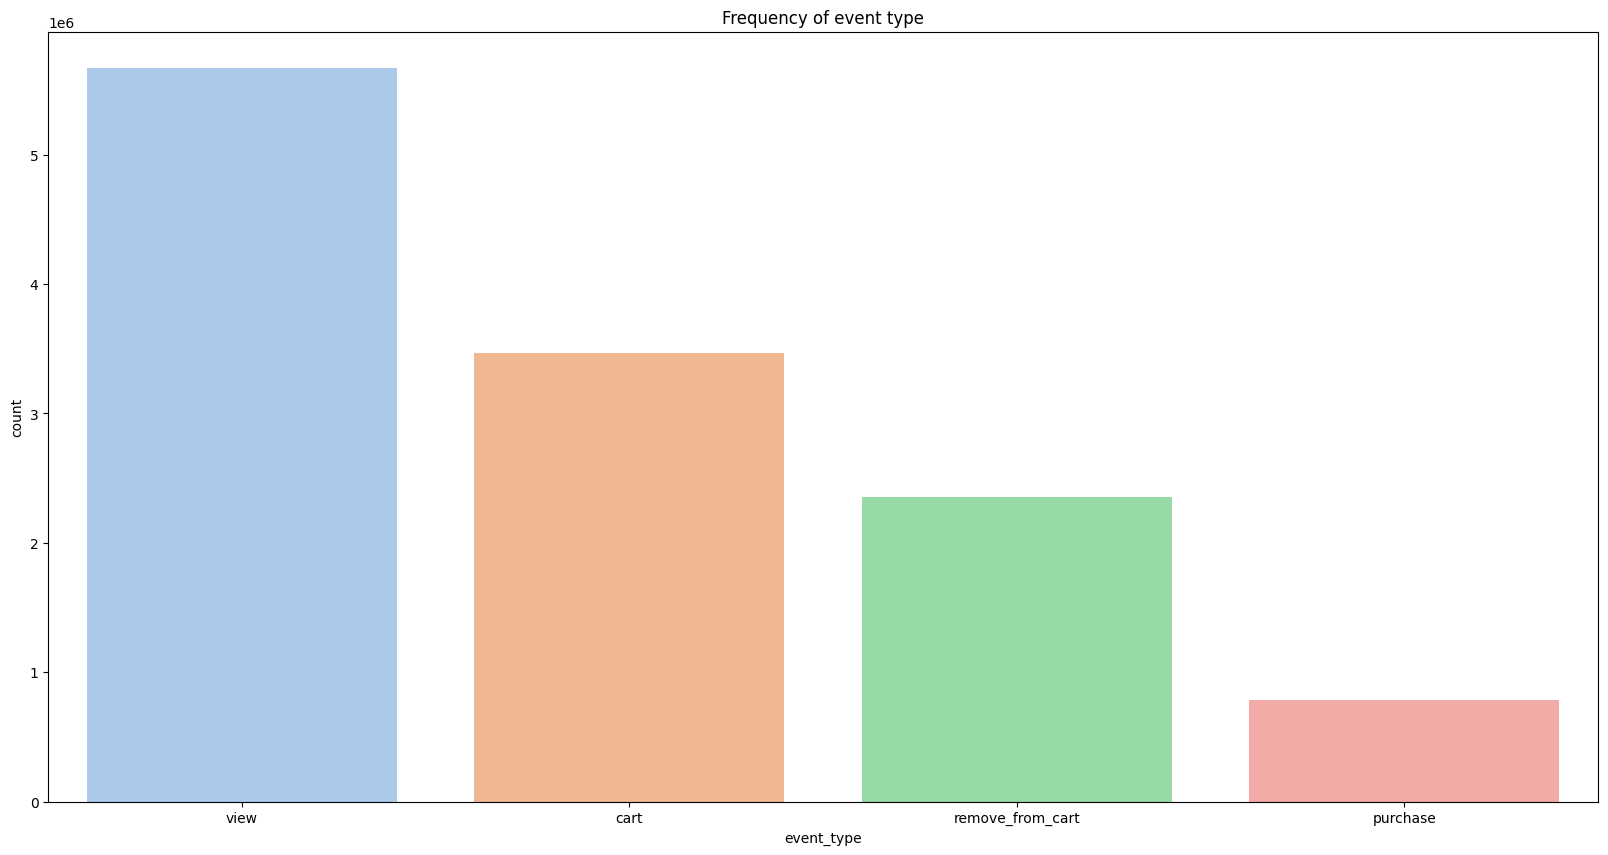

In [26]:
# ditribution of event_type

plt.figure(figsize=[20,10])
sns.countplot(data=training_data,
              x='event_type',order=training_data['event_type'].value_counts().index,palette='pastel')
plt.title(
    'Frequency of event type'
)

* There are more view event the data compared to the rest, which is understandable as users will be searching more in order to purchase their desired product.
* Add to cart also has a very good percentage as well as the remove from cart category which might signal, lost of interest to buy the product, seen a better deal or difficulty completing puchase.
* Volume of purchase seems to be the least event type while compared to the rest event type.

Text(0.5, 1.0, 'Distibution of price')

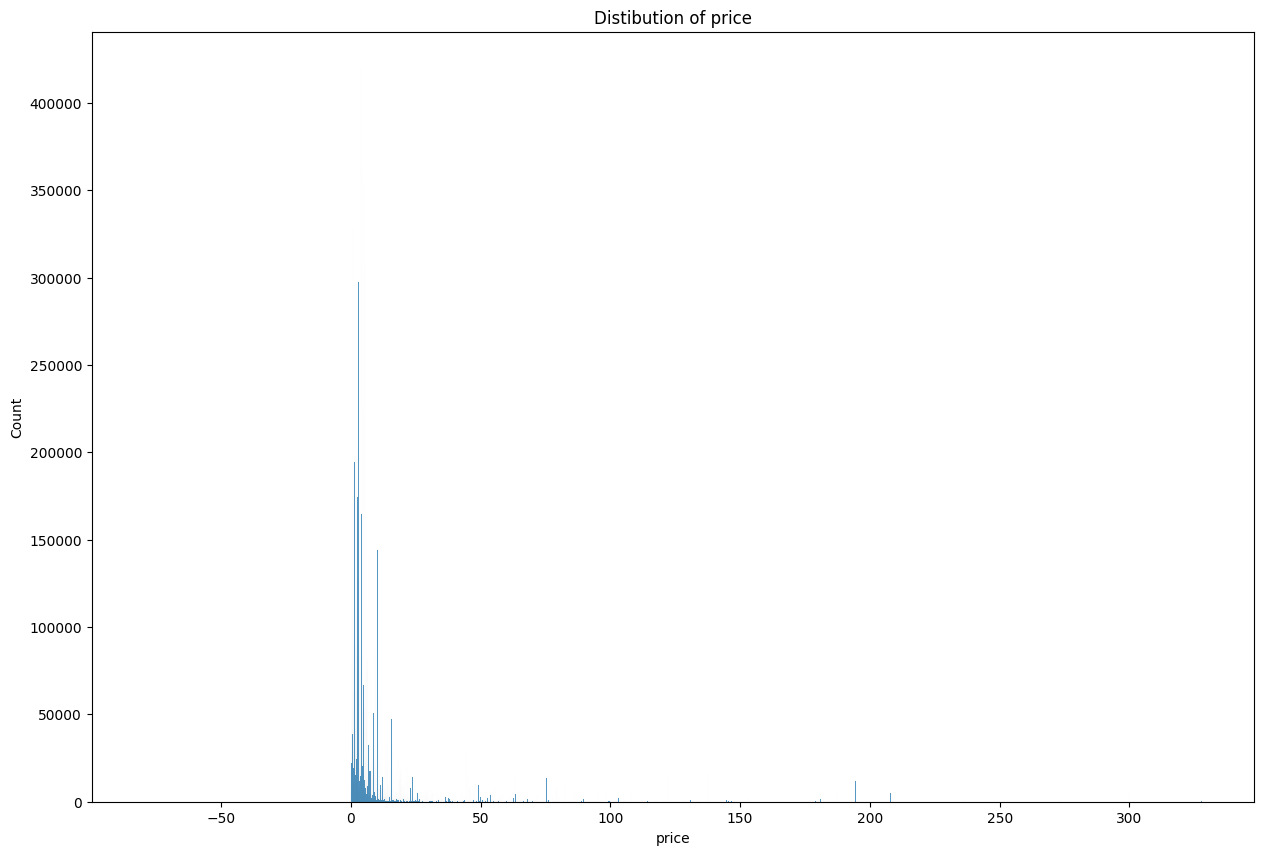

In [27]:
#  distribution of the price

plt.figure(figsize=[15,10])
sns.histplot(
    data=training_data,x='price'
)
plt.title('Distibution of price')

The price of product in the store are right skewed. Most cosmetics prices were around (which might be a free product on the store) to 20, with some extreme outlliers ranging to over 200

#### previous view before purchase



In [28]:
copy_training_data = training_data.copy()

copy_training_data

,event_type,product_id,category_id,brand,price,user_id,user_session
event_time,,,,,,,
2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...
2019-12-31 23:59:39+00:00,view,5683350,1487580005671109489,masura,2.84,536812729,e4a2d47c-a956-4c46-8176-745f52ea664b
2019-12-31 23:59:46+00:00,view,5888097,1487580013388628160,shik,179.05,503658154,2dde9867-9e71-4a64-880d-aa68b66aae6d
2019-12-31 23:59:51+00:00,view,59975,1487580012096782476,UNKNOWN,7.14,595414541,4c6d80bb-5dd3-4fbb-b592-187b51db2753


In [29]:
# get the number of views in a session

#groupby session,event_type

copy_training_data  = copy_training_data.sort_values(by=['user_id','user_session','event_time'])

copy_training_data['session_purchase'] = copy_training_data.groupby(['user_id','user_session'])['event_type'].transform(lambda x : 'purchase' in x.values)

In [30]:
copy_training_data

,event_type,product_id,category_id,brand,price,user_id,user_session,session_purchase
event_time,,,,,,,,
2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,False
2019-12-28 14:32:56+00:00,view,5881337,1487580012096782476,fedua,25.40,1180452,a4818e6d-9069-4aa8-8731-572ac266283f,False
2019-11-19 11:14:48+00:00,view,5814066,1487580005855658874,grattol,2.30,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,False
2019-11-20 11:58:06+00:00,view,5800358,1487580005553668971,UNKNOWN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,False
2019-11-20 11:58:27+00:00,view,5800349,1487580005553668971,UNKNOWN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,False
...,...,...,...,...,...,...,...,...
2019-12-31 23:55:52+00:00,view,5696330,1487580013841613016,estel,2.62,595413843,468fcf5a-56d4-4ec2-a73e-5403256fdd22,False
2019-12-31 23:55:33+00:00,view,5745711,1487580013950664926,runail,35.08,595413976,e29832b3-239a-491f-8fad-220fd3f1a5e8,False
2019-12-31 23:57:08+00:00,view,5886338,1814592470537732872,UNKNOWN,6.75,595414210,ebd2969c-dce1-451a-af8a-dce36c2e1687,False


In [31]:
# Filter for sessions with purchases
purchase_sessions = copy_training_data[copy_training_data['session_purchase']]
purchase_sessions

,event_type,product_id,category_id,brand,price,user_id,user_session,session_purchase
event_time,,,,,,,,
2019-11-25 04:54:27+00:00,view,5809912,1602943681873052386,grattol,5.24,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,True
2019-11-25 04:55:26+00:00,view,5773361,1487580005134238553,runail,2.62,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,True
2019-11-25 04:55:40+00:00,view,5811704,1487580005427839846,irisk,2.40,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,True
2019-11-25 04:55:45+00:00,view,5724305,1487580005427839846,irisk,2.10,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,True
2019-11-25 04:55:50+00:00,remove_from_cart,5724305,1487580005427839846,irisk,2.10,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,True
...,...,...,...,...,...,...,...,...
2019-12-31 22:38:55+00:00,purchase,8200,1487580010100293687,UNKNOWN,3.00,595376179,f3099b04-e972-476b-867c-baf10bea6a6e,True
2019-12-31 23:52:21+00:00,view,5831578,1487580011677352062,UNKNOWN,10.95,595413503,3d5af3a2-4a25-48df-b981-b8021915dfe8,True
2019-12-31 23:52:55+00:00,cart,5831578,1487580011677352062,UNKNOWN,10.95,595413503,3d5af3a2-4a25-48df-b981-b8021915dfe8,True


In [32]:

# Count previous views per session that led to a purchase
purchase_sessions['views_before_purchase'] = purchase_sessions.groupby(['user_id', 'user_session']).apply(
    lambda x: (x['event_type'] == 'view').cumsum()).reset_index(level=[0,1], drop=True)

# Display first few rows
print(purchase_sessions[['user_id', 'user_session', 'views_before_purchase']])

KeyboardInterrupt: 